In [2]:
import tensorflow as tf
import os
import random
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import MobileNetV2
from keras.regularizers import l2

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [4]:
data_dir = '/kaggle/input/test-ferdi/Dataset Image Classification'

In [5]:
filepaths=[]
labels=[]
allowed_extensions = ['.png', '.jpeg', '.jpg'] 
classlist=os.listdir(data_dir)
for img_class in classlist:
    classpath=os.path.join(data_dir,img_class)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(img_class)                   
Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')    
df=pd.concat([Fseries, Lseries], axis=1)
print (df.head())
print (df['labels'].value_counts())

                                           filepaths          labels
0  /kaggle/input/test-ferdi/Dataset Image Classif...  Martabak Telur
1  /kaggle/input/test-ferdi/Dataset Image Classif...  Martabak Telur
2  /kaggle/input/test-ferdi/Dataset Image Classif...  Martabak Telur
3  /kaggle/input/test-ferdi/Dataset Image Classif...  Martabak Telur
4  /kaggle/input/test-ferdi/Dataset Image Classif...  Martabak Telur
labels
Telur Balado      393
Rujak Cingur      302
Bubur Ayam        283
Bakso             280
Pempek            247
Lontong Balap     224
Rendang           220
Nasi Goreng       219
Rawon             214
Telur Dadar       214
Martabak Telur    193
Name: count, dtype: int64


In [6]:
train_dir = '/kaggle/working/train'
os.makedirs(train_dir, exist_ok=True)

test_dir = '/kaggle/working/test'
os.makedirs(test_dir, exist_ok=True)

validation_dir = '/kaggle/working/validation'
os.makedirs(validation_dir, exist_ok=True)

In [7]:
train_ratio = .8
test_ratio = .1
validation_ratio = 1 - (train_ratio + test_ratio)

In [8]:
train_data, validation_data = train_test_split(df, test_size=test_ratio, random_state=123)
train_data, test_data = train_test_split(train_data, test_size=validation_ratio, random_state=123)

In [ ]:
# Memindahkan file gambar ke direktori yang sesuai
import shutil

# Memindahkan file gambar ke direktori train
for index, row in train_data.iterrows():
    file_path = row['filepaths']
    label = row['labels']
    destination_dir = os.path.join(train_dir, label)
    os.makedirs(destination_dir, exist_ok=True)
    shutil.copy(file_path, destination_dir)

# Memindahkan file gambar ke direktori test
for index, row in test_data.iterrows():
    file_path = row['filepaths']
    label = row['labels']
    destination_dir = os.path.join(test_dir, label)
    os.makedirs(destination_dir, exist_ok=True)
    shutil.copy(file_path, destination_dir)

# Memindahkan file gambar ke direktori validation
for index, row in validation_data.iterrows():
    file_path = row['filepaths']
    label = row['labels']
    destination_dir = os.path.join(validation_dir, label)
    os.makedirs(destination_dir, exist_ok=True)
    shutil.copy(file_path, destination_dir)

In [9]:
print ('train_df length: ', len(train_data), '  test_df length: ', len(test_data), '  validation_df length: ', len(validation_data))

train_df length:  2259   test_df length:  251   validation_df length:  279


In [10]:
image_size = (224, 224)
batch_size = 20

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   #width_shift_range=0.2,
                                   #height_shift_range=0.2,
                                   shear_range=0.2,
                                   #zoom_range=0.1,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
)

Found 2253 images belonging to 11 classes.
Found 251 images belonging to 11 classes.
Found 278 images belonging to 11 classes.


In [11]:
def show_image_samples(gen):
    classes = train_generator.class_indices
    class_names = list(classes.keys())

    images, labels = next(gen)  # Get a sample batch from the generator
    plt.figure(figsize=(20, 20))
    length = len(labels)
    if length < 25:  # Show a maximum of 25 images
        r = length
    else:
        r = 25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image = images[i]
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = class_names[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

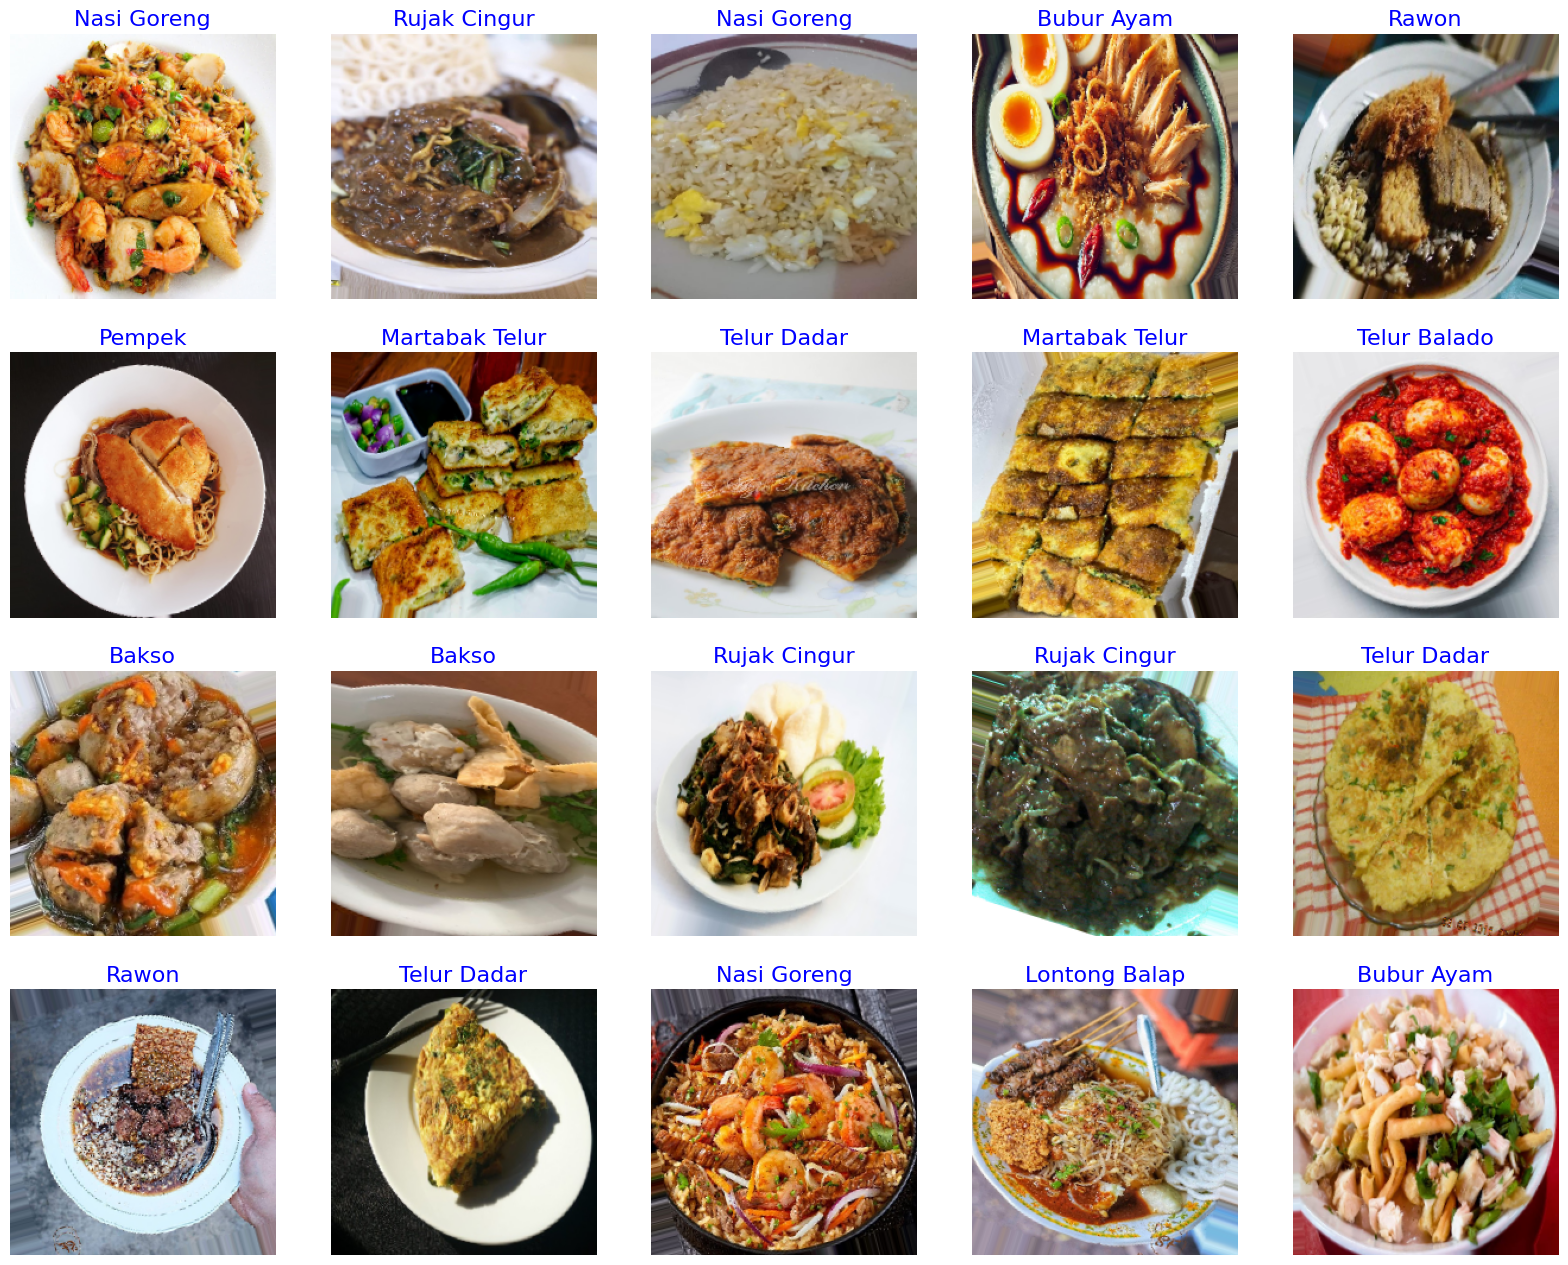

In [12]:
show_image_samples(train_generator)

In [13]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False


In [14]:
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Mengganti *flatten* untuk mengurangi overfitting
#x = Dense(256, activation='relu',kernel_regularizer=l2(0.01))(x)  # Tambahkan beberapa layer *dense*
x = Dense(128, activation='relu',kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)  # Tambahkan dropout untuk mengurangi overfitting
output_layer = Dense(11, activation='softmax')(x)  # Sesuaikan jumlah kelas dengan dataset Anda

model = Model(inputs=base_model.input, outputs=output_layer)


In [15]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
#model.summary()


In [16]:
class CustCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Logs berisi metrik yang dihitung selama training (misal: loss, accuracy)
        logs = logs or {}
        #print(f"Epoch {epoch + 1} selesai:")
        #for metric, value in logs.items():
           # print(f"  {metric}: {value:.4f}")
        
        # Contoh tambahan: Tindakan berdasarkan metrik
        if logs.get("accuracy") >= 0.93:
            print("Accuracy telah mencapai 93%. Menghentikan pelatihan.")
            self.model.stop_training = True

In [17]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
epochs= 55
verbose = 1

#total_samples = len(train_generator)*train_generator.batch_size
#steps_per_epoch = math.ceil(total_samples/batch_size)

# Callback untuk memberhentikan pelatihan jika val_accuracy tidak meningkat dalam 8 epoch
#early_stopping = EarlyStopping(monitor='val_accuracy', patience = 5, mode='max',baseline=0.98,restore_best_weights=True, verbose=1)

# Callback untuk menyimpan model terbaik berdasarkan val_accuracy
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

history = model.fit(
    train_generator,
    epochs=epochs,
    verbose=verbose,
    validation_data=validation_generator,
    callbacks=[CustCallback(),checkpoint]
)

Epoch 1/55


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1731940025.208554    1254 service.cc:145] XLA service 0x7a2f48003900 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731940025.208626    1254 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731940025.208631    1254 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/113 ━━━━━━━━━━━━━━━━━━━━ 24:07 13s/step - accuracy: 0.1500 - loss: 2.9771

I0000 00:00:1731940030.860123    1254 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.1804 - loss: 2.6975
Epoch 1: val_accuracy improved from -inf to 0.55755, saving model to best_model.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 60s 423ms/step - accuracy: 0.1818 - loss: 2.6929 - val_accuracy: 0.5576 - val_loss: 1.9158
Epoch 2/55
112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.4267 - loss: 1.9290
Epoch 2: val_accuracy improved from 0.55755 to 0.68705, saving model to best_model.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 40s 331ms/step - accuracy: 0.4275 - loss: 1.9271 - val_accuracy: 0.6871 - val_loss: 1.4767
Epoch 3/55
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.5680 - loss: 1.5781
Epoch 3: val_accuracy improved from 0.68705 to 0.75540, saving model to best_model.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 39s 328ms/step - accuracy: 0.5682 - loss: 1.5775 - val_accuracy: 0.7554 - val_loss: 1.2198
Epoch 4/55
112/113 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.6574 - loss: 1.3477
Epoch 4: val_accuracy improved from

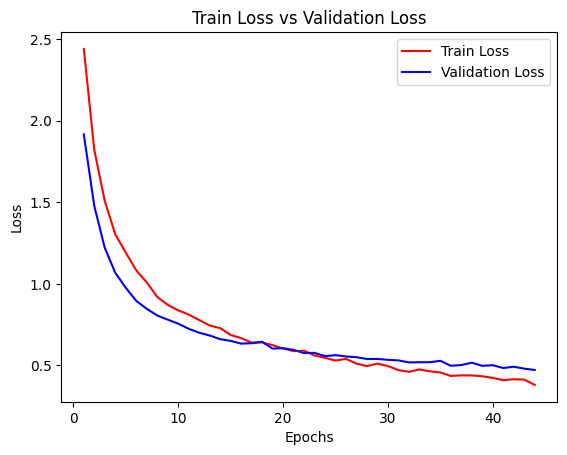

In [18]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plot train loss dan validation loss
plt.plot(epochs, train_loss, 'r', label='Train Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Train Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

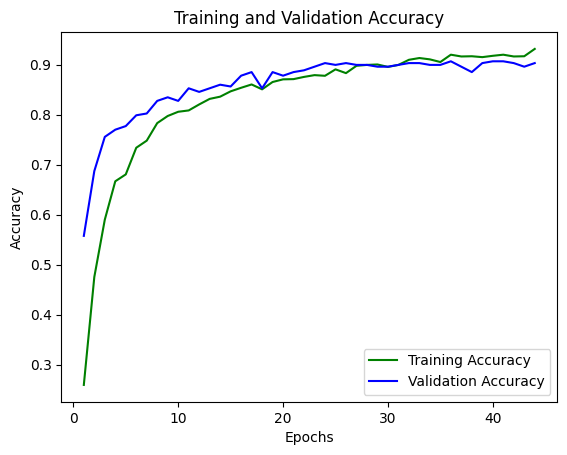

In [19]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_accuracy) + 1)

plt.plot(epochs, train_accuracy, 'g', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [20]:
# Evaluasi model
test_loss, test_acc = model.evaluate(test_generator)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 389ms/step - accuracy: 0.9102 - loss: 0.4796
Test Loss: 0.4608946442604065
Test Accuracy: 0.912350594997406


In [21]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

best_model = tf.keras.models.load_model('best_model.keras')

def predict_image(file, class_names):
    img = tf.keras.preprocessing.image.load_img(file, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    prediction = best_model.predict(img_array)
    predicted_class_index = np.argmax(prediction)
    predicted_probability = np.max(prediction)

    probabilities = [round(float(p), 3) for p in prediction[0]]

    for i in range(len(class_names)):
        print("Prediction probability for {0}: {1}%".format(class_names[i], probabilities[i] * 100))

    return class_names[predicted_class_index], predicted_probability

# File path
uploaded_file = '/kaggle/input/image-test-for-capstone2/image_test/telur dadar.jpg'

# Convert dict_keys to list
class_names_list = list(train_generator.class_indices.keys())

# Predict image class
predicted_class, predicted_probability = predict_image(uploaded_file, class_names_list)

print("Prediction:", predicted_class)
print("Probability:", predicted_probability)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Prediction probability for Bakso: 0.0%
Prediction probability for Bubur Ayam: 0.8999999999999999%
Prediction probability for Lontong Balap: 0.0%
Prediction probability for Martabak Telur: 2.6%
Prediction probability for Nasi Goreng: 2.4%
Prediction probability for Pempek: 5.2%
Prediction probability for Rawon: 0.0%
Prediction probability for Rendang: 1.0%
Prediction probability for Rujak Cingur: 1.0999999999999999%
Prediction probability for Telur Balado: 6.5%
Prediction probability for Telur Dadar: 80.2%
Prediction: Telur Dadar
Probability: 0.8022104


In [22]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report

highest_model = load_model('best_model.keras')
# Mengumpulkan prediksi model untuk data uji
y_pred = highest_model.predict(test_generator)
y_pred_labels = np.argmax(y_pred, axis=1)

# Mengambil label sebenarnya dari generator
y_true_labels = test_generator.classes

# Mendapatkan nama kelas dari generator
class_names = list(test_generator.class_indices.keys())

# Membuat classification report
report = classification_report(y_true_labels, y_pred_labels, target_names=class_names)

# Menampilkan classification report
print(report)

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 342ms/step
                precision    recall  f1-score   support

         Bakso       0.10      0.11      0.11        27
    Bubur Ayam       0.04      0.04      0.04        26
 Lontong Balap       0.08      0.08      0.08        12
Martabak Telur       0.23      0.20      0.21        25
   Nasi Goreng       0.06      0.06      0.06        16
        Pempek       0.20      0.23      0.21        22
         Rawon       0.06      0.06      0.06        18
       Rendang       0.05      0.05      0.05        20
  Rujak Cingur       0.17      0.18      0.18        28
  Telur Balado       0.19      0.18      0.19        38
   Telur Dadar       0.06      0.05      0.05        19

      accuracy                           0.12       251
     macro avg       0.11      0.11      0.11       251
  weighted avg       0.12      0.12      0.12       251



In [23]:
import numpy as np
from sklearn.metrics import classification_report

# Mengumpulkan semua prediksi dan label sebenarnya
y_true = []
y_pred = []

for batch_idx in range(len(validation_generator)):
  # Dapatkan batch data dan label
  images, labels = validation_generator[batch_idx]

  # Prediksi label untuk batch
  predictions = model.predict(images)
  predicted_labels = np.argmax(predictions, axis=1)
  true_labels = np.argmax(labels, axis=1)

  # Tambahkan ke daftar prediksi dan label sebenarnya
  y_true.extend(true_labels)
  y_pred.extend(predicted_labels)

# Menghasilkan classification report
target_names = list(validation_generator.class_indices.keys())  # Nama kelas
report = classification_report(y_true, y_pred, target_names=target_names)

print(report)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
                precision    recall  f1-score   support

         Bakso       1.00      0.96      0.98        27
    Bubur Ayam       0.90      0.82      0.86        33
 Lontong Balap       1.00      0.85      0.92        27
Martabak Telur       0.83      0.62      0.71        16
   Nasi Goreng       0.90      1.00      0.95        19
        Pempek       0.93      0.93      0.93        30
         Rawon       0.87      1.00      0.93        20
       Rendang       0.

In [24]:

from tensorflow.keras.preprocessing import image

def predict_image(img_path):
    # Load image
    img = image.load_img(img_path, target_size=(224, 224))  # Pastikan ukuran gambar sesuai dengan yang diinginkan
    img_array = image.img_to_array(img) / 255.0  # Normalisasi gambar
    img_array = np.expand_dims(img_array, axis=0)  # Menambahkan dimensi batch (None, 224, 224, 3)

    # Prediksi dengan model
    predictions = model.predict(img_array)

    # Mendapatkan label kelas
    class_idx = np.argmax(predictions[0])
    class_label = list(train_generator.class_indices.keys())[class_idx]

    print(f"Predicted Class for {os.path.basename(img_path)}: {class_label}")

def predict_images_in_folder(folder_path):
    # Mengambil semua file gambar dari folder
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        # Memastikan hanya file gambar yang diproses
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            predict_image(img_path)

# Path ke folder yang berisi gambar
test_folder_path = '/kaggle/input/image-test-for-capstone2/image_test'
predict_images_in_folder(test_folder_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 974ms/step
Predicted Class for rujakcingur.jpg: Rujak Cingur
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted Class for bubu2r.jpg: Bubur Ayam
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted Class for ruajk cingur.jpg: Rujak Cingur
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted Class for nasi goreng.jpg: Nasi Goreng
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted Class for martabak telur (2).jpg: Martabak Telur
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted Class for 62dbd7ac6e943.jpg: Bubur Ayam
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted Class for bakso (2).jpg: Bakso
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted Class for Lontong balap2.jpg: Lontong Balap
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted Class for rendangs.jpg: Rendang
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted Class for telur balado (2).jpg: Telur Balado
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted Class for testsst.jpg: Pempek
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted

In [25]:
print("Class Indices (Label Mapping):", train_generator.class_indices)

Class Indices (Label Mapping): {'Bakso': 0, 'Bubur Ayam': 1, 'Lontong Balap': 2, 'Martabak Telur': 3, 'Nasi Goreng': 4, 'Pempek': 5, 'Rawon': 6, 'Rendang': 7, 'Rujak Cingur': 8, 'Telur Balado': 9, 'Telur Dadar': 10}


In [27]:
import pandas as pd

# Dapatkan class indices
class_indices = train_generator.class_indices

# Konversi ke DataFrame
df = pd.DataFrame(list(class_indices.items()), columns=["Class Name", "Label"])

# Simpan ke file CSV
df.to_csv("class_indices.csv", index=False)

print("Class Indices saved to class_indices.csv!")

# Direktori tempat file akan disimpan
directory = "/kaggle/working/my_directory"
filename = "class_indices.csv"
filepath = os.path.join(directory, filename)

# Pastikan direktori ada, jika tidak, buat
os.makedirs(directory, exist_ok=True)

# Dapatkan class indices
class_indices = train_generator.class_indices

# Konversi ke DataFrame
df = pd.DataFrame(list(class_indices.items()), columns=["Class Name", "Label"])

# Simpan ke file CSV di direktori tertentu
df.to_csv(filepath, index=False)

print(f"Class Indices saved to {filepath}!")


Class Indices saved to class_indices.csv!
Class Indices saved to /kaggle/working/my_directory/class_indices.csv!


In [29]:
model.save_weights('/kaggle/working/Final_model_weights_keras2.weights.h5')

In [30]:
model.save('/kaggle/working/Finalmodel_keras2.h5')

In [31]:
import tensorflow as tf
import json

# Load the .h5 model
model = tf.keras.models.load_model('/kaggle/working/Finalmodel_keras2.h5')

# Save the model architecture to a JSON file
model_json = model.to_json()

with open('model_architecture.json', 'w') as json_file:
    json_file.write(model_json)

print("Model architecture has been saved as JSON.")


Model architecture has been saved as JSON.


In [32]:
import numpy as np

# Extract the weights from the model
weights = model.get_weights()

# Save weights into a .bin file
with open('model_weights.bin', 'wb') as bin_file:
    for weight_array in weights:
        weight_array.astype(np.float32).tofile(bin_file)

print("Model weights have been saved as .bin.")


Model weights have been saved as .bin.
